# Рубежная контрольная работа

Эту работу выполнять не обязательно. Баллы набранные за работу просуммируются с баллами, которые были набраны за контрольную работу 1 и выставлены как оценка за промежуточную аттестацию "автоматом". 

Сделайте копию ноутбука

Присвойте переменной `v` значение свой табельный номер ИСУ, это нужно для определения вашего варианта. Запустите код в следующей ячейке.

In [1]:
from datetime import datetime
current_datetime = datetime.now()
print(current_datetime)
v = 311486 # по умолчанию вписан мой номер

2022-12-14 09:48:59.793564


In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import warnings

from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report

%matplotlib inline
warnings.filterwarnings('ignore')

# Общее задание

Нужно решить задачу бинарной классификации, предварительно построив признаковое описание объектов на основе нескольких таблиц. 

Целевая переменная - пол клиента.

В качестве модели нужно использовать нейронную сеть, которую нужно строить с помощью `keras` или `torch` на выбор студента.

# Данные

Для всех последующих заданий будем использовать обезличенные транзакционные банковские данные. Для этого считайте в переменные **transactions, tr_mcc_codes и gender_train** из одноимённых таблиц из папки data. Для таблицы transactions используйте только первые n=1000000 строк.

Эти данные уже использовались в работе 2. Описание данных тут: https://drive.google.com/file/d/13sn8orjkoGfO1SVZYByXNmZQYFRfmOdp/view?usp=sharing

Скачать данные отсюда: https://drive.google.com/drive/folders/1YAMe7MiTxA-RSSd8Ex2p-L0Dspe6Gs4L?usp=sharing

## Задание 1 (6 баллов)

В задании требуется на основе нескольких таблиц с данными сделать признаковое описание объектов. 

Объектами являются клиенты. Клиенты идентифицируются с помощью `customer_id`, которые есть в таблицах **transactions** и **gender_train**. В качестве призаков нужно использовать даннее по категориям транзаций: ```mcc_code``` — mcc-код транзакции есть в таблицах **transactions** и **tr_mcc_codes**


Для выбора варианта, запустите код в следующей ячейке



### Импортируем данные

In [3]:
print('Список категорий')
feature_list = ['Одежда (также нужно искать "одежды")', 'Аптеки', 'Ценные бумаги', 
                'Магазины косметики и Салоны красоты', 'Образовательные услуги (а также школы, университеты)',
                'Алименты', 'Прокат автомобилей', 'Автозапчасти, Автошины и Станции техобслуживания (а также СТО)', 
                'Видеоигры (искать надо по "видеоигр")', 'Отели', 'Программирование', 'Спиртное и алкоголь', 
                'Предсказатели будущего', 'Азартные игры']

if (int(str(v)[4]) % 2) == 0:
  print(feature_list[::2])
else:
  print(feature_list[::-2])


if (int(str(v)[5]) % 2) == 0:
  print('В качестве значений признаков используйте количество транзакций с тратами и количество транзакций с поступлениями')
else: 
  print('В качестве значений признаков используйте сумму по транзакциям с тратами и сумму по транзакциям с поступлениями')

Список категорий
['Одежда (также нужно искать "одежды")', 'Ценные бумаги', 'Образовательные услуги (а также школы, университеты)', 'Прокат автомобилей', 'Видеоигры (искать надо по "видеоигр")', 'Программирование', 'Предсказатели будущего']
В качестве значений признаков используйте количество транзакций с тратами и количество транзакций с поступлениями


Каждая категория может быть связана с одним или несколькими mcc-кодами. Например, вот несколько mcc-кодов по категории "Одежда": 
* 5621; Готовая женская одежда
* 5641; Детская одежда
* 5651; Одежда для всей семьи

Таким образом получится 14 признаков, то есть семь категорий, каждая из которых даст два значения: траты и поступления. Например, категория "Одежда" даёт признаки "Одежда траты" и "Одежда поступления".

Сделайте нормализацию значений признаков так, чтобы все означения менялись от 0 до 1. 

In [4]:
from google.colab import drive


drive.mount('/google_drive')

Drive already mounted at /google_drive; to attempt to forcibly remount, call drive.mount("/google_drive", force_remount=True).


In [5]:
TRANSACTION_SAMPLE_SIZE = 10 ** 6

tr_mcc_codes = pd.read_csv(
    "/google_drive/MyDrive/Data/tr_mcc_codes.csv", 
    sep=";")

gender_train = pd.read_csv(
    "/google_drive/MyDrive/Data/gender_train.csv", 
    sep=",")

transactions = pd.read_csv(
    "/google_drive/MyDrive/Data/transactions.csv", 
    sep=",", 
    nrows=TRANSACTION_SAMPLE_SIZE)

In [6]:
transactions

,customer_id,tr_datetime,mcc_code,tr_type,amount,term_id
0,39026145,0 10:23:26,4814,1030,-2245.92,NaN
1,39026145,1 10:19:29,6011,7010,56147.89,NaN
2,39026145,1 10:20:56,4829,2330,-56147.89,NaN
3,39026145,1 10:39:54,5499,1010,-1392.47,NaN
4,39026145,2 15:33:42,5499,1010,-920.83,NaN
...,...,...,...,...,...,...
999995,98801178,269 10:29:06,5921,1010,-23016.59,127873
999996,98801178,270 10:26:45,5211,1010,-61380.88,10114209
999997,98801178,270 15:18:53,5921,1010,-11800.27,10105341
999998,98801178,271 12:47:13,5211,1010,-16170.59,10114209


In [7]:
gender_train

,customer_id,gender
0,10928546,1
1,69348468,1
2,61009479,0
3,74045822,0
4,27979606,1
...,...,...
8395,90417572,0
8396,66837341,0
8397,10758984,1
8398,11376556,0


In [8]:
tr_mcc_codes

,mcc_code,mcc_description
0,742,Ветеринарные услуги
1,1711,"Генеральные подрядчики по вентиляции, теплосна..."
2,1731,Подрядчики по электричеству
3,1799,"Подрядчики, специализированная торговля — нигд..."
4,2741,Разнообразные издательства/печатное дело
...,...,...
179,9211,"Судовые выплаты, включая алименты и детскую по..."
180,9222,Штрафы
181,9311,Налоговые платежи
182,9399,"Правительственные услуги, нигде ранее не класс..."


### Отфильтруем необходимые категории товаров и назначим им номер

In [9]:
analysed_categories = ["одежд", "ценные бумаги", "образовательные услуги", "школы", "университет",
                       "прокат автомобилей", "видеоигр", "программирование", "предсказатели будущего"]

tr_mcc_codes_filtered = tr_mcc_codes[
    tr_mcc_codes.mcc_description.str.contains("|".join(analysed_categories), case=False)]
for index, category in enumerate(analysed_categories):
    tr_mcc_codes_filtered.loc[
        tr_mcc_codes_filtered.mcc_description.str.contains(category, case=False), "category"] = index + 1

transition_dict = {"category": {4: 3, 5: 3, 6: 4, 7: 5, 8: 6, 9: 7}}
tr_mcc_codes_filtered = tr_mcc_codes_filtered.replace(transition_dict)

tr_mcc_codes_filtered

,mcc_code,mcc_description,category
39,5137,"Мужская, женская и детская спец-одежда",1.0
69,5611,"Мужская одежда и аксессуары, включая одежду дл...",1.0
70,5621,Готовая женская одежда,1.0
72,5641,"Детская одежда, включая одежду для самых мален...",1.0
73,5651,Одежда для всей семьи,1.0
74,5655,"Спортивная одежда, одежда для верховой езды и ...",1.0
77,5691,Магазины мужской и женской одежды,1.0
78,5697,"Услуги по переделке, починке и пошиву одежды",1.0
79,5699,Различные магазины одежды и аксессуаров,1.0
127,6211,Ценные бумаги: брокеры/дилеры,2.0


### Соединим все имеющиеся данные в одну таблицу

В данном коде я использую inner join, т.к. для обучения модели нам не подходят клиенты, у которых не указан пол (значения NaN в этой графе нас не интересуют)

In [10]:
data = pd.merge(transactions, gender_train, how="inner", on="customer_id")
data = pd.merge(data, tr_mcc_codes_filtered, how="inner", on="mcc_code")

data

,customer_id,tr_datetime,mcc_code,tr_type,amount,term_id,gender,mcc_description,category
0,39026145,372 08:45:27,5621,1010,-31442.82,097179,1,Готовая женская одежда,1.0
1,39026145,372 08:48:29,5621,1010,-11229.58,097179,1,Готовая женская одежда,1.0
2,1585299,407 10:38:46,5621,1010,-57158.56,303501,1,Готовая женская одежда,1.0
3,1585299,455 12:56:02,5621,1010,-167769.91,303501,1,Готовая женская одежда,1.0
4,3765322,3 16:41:55,5621,1110,-41470.83,NaN,0,Готовая женская одежда,1.0
...,...,...,...,...,...,...,...,...,...
8436,94969511,445 00:00:00,5137,1110,-26950.99,23482301,0,"Мужская, женская и детская спец-одежда",1.0
8437,5000075,144 00:00:00,5137,1110,-7411.52,NaN,1,"Мужская, женская и детская спец-одежда",1.0
8438,67138881,157 09:27:52,5137,1110,-33688.74,NaN,0,"Мужская, женская и детская спец-одежда",1.0
8439,67138881,157 09:28:49,5137,1110,-6288.56,NaN,0,"Мужская, женская и детская спец-одежда",1.0


### Подсчитаем транзакции дохода и расхода для каждого клиента и категории

In [11]:
data_aggregated = data.groupby(["customer_id", "gender", "category"]).amount
data_aggregated = data_aggregated.agg(pos_count=lambda s: s.gt(0).sum(), neg_count=lambda s: s.lt(0).sum())

data_aggregated

,,,pos_count,neg_count
customer_id,gender,category,,
115617,1,1.0,0,8
117556,0,1.0,0,2
189257,1,1.0,0,8
293048,0,1.0,0,12
361458,1,1.0,0,4
...,...,...,...,...
99302313,1,1.0,0,2
99412328,0,1.0,0,11
99683064,0,1.0,0,2


### Составим таблицу с искомыми 14 параметрами

In [12]:
prep_data_dict = {}
for row in data_aggregated.iterrows():
    customer_id, gender, data_category = row[0]
    pos_count, neg_count = row[1]

    customer_dict = {}
    for category in range(1, 8):
        pos_name, neg_name = f"pos_count_cat_{category}", f"neg_count_cat_{category}"
        customer_dict[pos_name], customer_dict[neg_name] = 0, 0

        if category == data_category:
            customer_dict[pos_name] = pos_count
            customer_dict[neg_name] = neg_count

    prep_data_dict[customer_id, gender] = customer_dict

In [13]:
prep_data = pd.DataFrame.from_dict(prep_data_dict, orient="index")
prep_data = prep_data.reset_index()
prep_data = prep_data.rename(columns={"level_0": "customer_id", "level_1": "gender"})

prep_data

,customer_id,gender,pos_count_cat_1,neg_count_cat_1,pos_count_cat_2,neg_count_cat_2,pos_count_cat_3,neg_count_cat_3,pos_count_cat_4,neg_count_cat_4,pos_count_cat_5,neg_count_cat_5,pos_count_cat_6,neg_count_cat_6,pos_count_cat_7,neg_count_cat_7
0,115617,1,0,8,0,0,0,0,0,0,0,0,0,0,0,0
1,117556,0,0,2,0,0,0,0,0,0,0,0,0,0,0,0
2,189257,1,0,8,0,0,0,0,0,0,0,0,0,0,0,0
3,293048,0,0,12,0,0,0,0,0,0,0,0,0,0,0,0
4,361458,1,0,4,0,0,0,0,0,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
708,99302313,1,0,2,0,0,0,0,0,0,0,0,0,0,0,0
709,99412328,0,0,11,0,0,0,0,0,0,0,0,0,0,0,0
710,99683064,0,0,2,0,0,0,0,0,0,0,0,0,0,0,0
711,99717689,1,0,2,0,0,0,0,0,0,0,0,0,0,0,0


## Вопросы к заданию 1

1. Для каждой категории выведите соответствующие ей mcc-коды с описаниями.
2. По какому признакому самое большое количество непустых значений?
3. По какой категории самая большая разница между мужчинами и женщинами?

## Ответы:

### Вопрос №1

In [14]:
tr_mcc_codes_filtered

,mcc_code,mcc_description,category
39,5137,"Мужская, женская и детская спец-одежда",1.0
69,5611,"Мужская одежда и аксессуары, включая одежду дл...",1.0
70,5621,Готовая женская одежда,1.0
72,5641,"Детская одежда, включая одежду для самых мален...",1.0
73,5651,Одежда для всей семьи,1.0
74,5655,"Спортивная одежда, одежда для верховой езды и ...",1.0
77,5691,Магазины мужской и женской одежды,1.0
78,5697,"Услуги по переделке, починке и пошиву одежды",1.0
79,5699,Различные магазины одежды и аксессуаров,1.0
127,6211,Ценные бумаги: брокеры/дилеры,2.0


### Вопрос №2

In [15]:
result_q2 = prep_data.drop(["customer_id", "gender"], axis=1).astype(bool).sum(axis=0).to_frame()
result_q2 = result_q2.rename(columns={0: "count"})

print("Признак с самым большим количеством непустых значений:")
result_q2.sort_values(by="count", ascending=False).head(1)

Признак с самым большим количеством непустых значений:


,count
neg_count_cat_1,609


### Вопрос №3

In [39]:
result_q3 = prep_data.groupby("gender").sum().drop("customer_id", axis=1)
result_q3.loc["difference"] = result_q3.loc[0] - result_q3.loc[1]
diff = result_q3.loc["difference"].values
category_diff = np.array([np.abs(diff[2 * i] + diff[2 * i + 1]) for i in range(diff.shape[0] // 2)])

print(f"Категория с наибольшей разницей под номером: {np.argmax(category_diff) + 1}")

Категория с наибольшей разницей под номером: 1


# Задание 2 (3 балла)

Модель - многослойная нейронная сеть минимум с двумя скрытыми слоями и с dropout. Количество нейронов в каждом слое выбираете самостоятельно.
Функции активации, метод оптимизации, скорость обучения, вероятность dropout - выбираете самостоятельно

Модель нужно строить с помощью keras или torch

Настроить параметры модели.

In [17]:
import torch

from torch.utils.data import Dataset, DataLoader
from torch import nn
from torch import optim
from tqdm.auto import tqdm

### Импортируем данные

In [18]:
data_cp = prep_data.copy(deep=True).drop(columns=["customer_id"])

data_cp

,gender,pos_count_cat_1,neg_count_cat_1,pos_count_cat_2,neg_count_cat_2,pos_count_cat_3,neg_count_cat_3,pos_count_cat_4,neg_count_cat_4,pos_count_cat_5,neg_count_cat_5,pos_count_cat_6,neg_count_cat_6,pos_count_cat_7,neg_count_cat_7
0,1,0,8,0,0,0,0,0,0,0,0,0,0,0,0
1,0,0,2,0,0,0,0,0,0,0,0,0,0,0,0
2,1,0,8,0,0,0,0,0,0,0,0,0,0,0,0
3,0,0,12,0,0,0,0,0,0,0,0,0,0,0,0
4,1,0,4,0,0,0,0,0,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
708,1,0,2,0,0,0,0,0,0,0,0,0,0,0,0
709,0,0,11,0,0,0,0,0,0,0,0,0,0,0,0
710,0,0,2,0,0,0,0,0,0,0,0,0,0,0,0
711,1,0,2,0,0,0,0,0,0,0,0,0,0,0,0


### Используем MinMaxScaler, чтобы проскалировать данные в промежутке (0, 1)

In [19]:
scaler = MinMaxScaler()

data_cp[data_cp.columns] = scaler.fit_transform(data_cp[data_cp.columns])

data_cp

,gender,pos_count_cat_1,neg_count_cat_1,pos_count_cat_2,neg_count_cat_2,pos_count_cat_3,neg_count_cat_3,pos_count_cat_4,neg_count_cat_4,pos_count_cat_5,neg_count_cat_5,pos_count_cat_6,neg_count_cat_6,pos_count_cat_7,neg_count_cat_7
0,1.0,0.0,0.088889,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,0.0,0.0,0.022222,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,1.0,0.0,0.088889,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,0.0,0.0,0.133333,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,1.0,0.0,0.044444,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
708,1.0,0.0,0.022222,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
709,0.0,0.0,0.122222,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
710,0.0,0.0,0.022222,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
711,1.0,0.0,0.022222,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


### Создадим тестовую и тренировочную выборки

In [20]:
x_train, x_test, y_train, y_test = train_test_split(data_cp.drop("gender", axis=1), data_cp.gender, test_size=0.2)
BATCH_SIZE = 64

class Data(Dataset):
    def __init__(self, x: np.array, y: np.array):
        self.x = torch.from_numpy(x.astype(np.float32))
        self.y = torch.from_numpy(y.astype(np.int64))
        self.len = self.x.shape[0]
       
    def __getitem__(self, index):
        return self.x[index], self.y[index]
   
    def __len__(self):
        return self.len

train_ds = Data(x_train.values, y_train.values)
train_dataloader = DataLoader(dataset=train_ds, batch_size=BATCH_SIZE, shuffle=True)

test_ds = Data(x_test.values, y_test.values)
test_dataloader = DataLoader(dataset=test_ds, batch_size=BATCH_SIZE, shuffle=True)

### Создадим модель нейронной сети

In [21]:
LEARNING_RATE = 0.1
INPUT_DIMENSIONS = 14
HIDDEN_DIMENSIONS = (64, 32)
OUTPUT_DIMENSIONS = 2
DROPOUT = 0.2

class Model(nn.Module):
    def __init__(self, input_dimensions, hidden_dimensions, output_dimensions):
        super(Model, self).__init__()
        self._input_dimensions = input_dimensions
        self._hidden_dimensions = hidden_dimensions
        self._output_dimensions = output_dimensions
        self.layer1 = nn.Sequential(
            nn.Linear(self._input_dimensions, self._hidden_dimensions[0]),
            nn.BatchNorm1d(self._hidden_dimensions[0]),
            nn.LeakyReLU(),
            nn.Dropout(DROPOUT)
        )

        self.layer2 = nn.Sequential(
            nn.Linear(self._hidden_dimensions[0], self._hidden_dimensions[0]),
            nn.BatchNorm1d(self._hidden_dimensions[0]),
            nn.LeakyReLU(),
            nn.Dropout(DROPOUT)
        )

        self.layer3 = nn.Sequential(
            nn.Linear(self._hidden_dimensions[0], self._hidden_dimensions[1]),
            nn.BatchNorm1d(self._hidden_dimensions[1]),
            nn.LeakyReLU(),
            nn.Dropout(DROPOUT)
        )

        self.fc = nn.Sequential(
            nn.Linear(self._hidden_dimensions[1], self._output_dimensions)
        )
        
       
    def forward(self, x):
        x = self.layer1(x)
        x = self.layer2(x)
        x = self.layer3(x)
        x = self.fc(x)
        return x

In [22]:
model = Model(INPUT_DIMENSIONS, HIDDEN_DIMENSIONS, OUTPUT_DIMENSIONS)
model.train()

loss_function = nn.CrossEntropyLoss()

optimizer = torch.optim.Adam(model.parameters(), lr=LEARNING_RATE)

В loss values добавляю значение только каждой 1000 эпохи, чтобы можно было различить динамику на графике.

In [23]:
def fit(model, optimizer, loss_function, trainloader, epochs):
    loss_values = np.array([])
    divider = epochs // 10

    for epoch in tqdm(range(epochs)):
        for x, y in trainloader:
            optimizer.zero_grad()

            pred = model(x)
            loss = loss_function(pred, y)
            loss.backward()
            optimizer.step()

            if epoch % divider == 999:
                loss_values = np.append(loss_values, loss.item())
                
    return loss_values

In [24]:
NUM_EPOCHS = 10 ** 4

loss_values = fit(model, optimizer, loss_function, train_dataloader, NUM_EPOCHS)

  0%|          | 0/10000 [00:00<?, ?it/s]

In [25]:
def plot_loss_function(loss_values):
    plt.figure(figsize=(10, 10))
    plt.plot(np.array(loss_values))
    plt.title("Step-wise Loss")
    plt.xlabel("Epochs")
    plt.ylabel("Loss")
    plt.show()

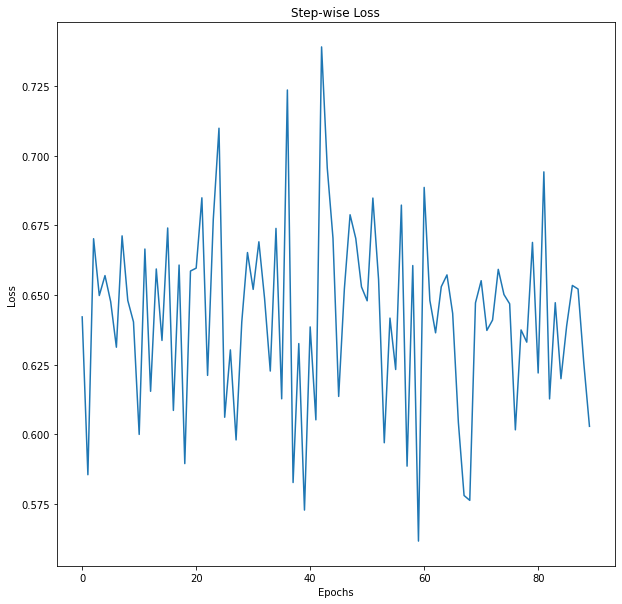

In [26]:
plot_loss_function(loss_values)

## Вопросы к заданию 2

1. Перечислите все гиперпараметры и их значения вот в таком формате (значения приведены примерные, у вас могут быть другие):

* количество эпох: 5
* скорость обучения: 0.0001
* функция активация на скрытых слоях: ReLU
* и т.д.

2. Сколько у вашей модели параметров?

## Ответы:

### Вопрос №1

Я использовал следущие параметры:

1.   Количество эпох: 10 ** 4
2.   Коэффициент обучения: 0.1
3.   Функция активации на скрытых слоях: LeakyReLU
4.   Количество скрытых слоёв: 2
5.   Количество измерений скрытых слоёв: (64, 64); (64, 32)
6.   Размер выборки: 64
7.   Функция потерь: Cross Entropy Loss
8.   Оптимайзер: Adam Algorithm
9.   Процент dropout: 20%

### Вопрос №2

Из предыдущего пункта можно заключить, что у моей модели 9 основных параметров.

# Задание 3 (2 балла)


Проверить качество модели не менее, чем на трёх разных метриках. 

In [27]:
def report(model, test_dataloader):
    y_pred_arr = np.array([])
    y_test_arr = np.array([])

    model.eval()

    with torch.no_grad():
        for x, y in test_dataloader:
            outputs = model(x)

            y_pred = torch.argmax(outputs, dim=1).detach()
            y_pred_arr = np.append(y_pred_arr, y_pred)
            y_test_arr = np.append(y_test_arr, y)

    return classification_report(y_pred=y_pred_arr, y_true=y_test_arr)

## Вопросы к заданию 3

1. Выведите значения метрик.
2. Как улучшить модель?
3. Для чего может понадобиться предсказание пола клиента по его транзакциям?

### Вопрос №1

In [28]:
print(report(model, test_dataloader))

              precision    recall  f1-score   support

         0.0       0.58      0.96      0.72        82
         1.0       0.57      0.07      0.12        61

    accuracy                           0.58       143
   macro avg       0.58      0.51      0.42       143
weighted avg       0.58      0.58      0.47       143



### Вопрос №2



Чтобы улучшить модель, можно предпринять следующие шаги:


*   Подобрать более релеватные гиперпараметры.
*   Изменить саму модель Нейронной сети (количество слоёв, их наполнение)
*   Поработать с набором данных для анализа (выборка по категориям несбалансирована, у респондентов в основном всего 1 ненулевой признак из 14)

### Вопрос №3

Такой анализ может пригодиться, к примеру, для вывода контекстной рекламы. Весьма логично предлагать женщине женскую одежду, а мужчине - мужскую.

## Ответы:

После завершения контрольной работы, дайте ссылку на colab в отдельном followup в своей теме на Piazza. Дайте разрешение на его просмотр.

Не забудьте запустить код в последней ячейке для контроля времени выполнения.

In [41]:
current_datetime = datetime.now()
print(current_datetime)

2022-12-14 10:08:43.438123
